In [1]:
import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

from constants import exclude_models, exclude_models_w_mae, ds_name_mapping, cat_name_mapping
from helper import load_model_configs_and_allowed_models, save_or_show

sys.path.append('..')
from scripts.helper import parse_datasets

In [2]:
# base_path_aggregated = '/home/space/diverse_priors/results/aggregated'
base_path_aggregated = Path('/Users/lciernik/Documents/TUB/projects/divers_prios/results/aggregated')

### Config similarity data
sim_data = pd.read_csv(base_path_aggregated / 'model_sims/all_metric_ds_model_pair_similarity.csv')

### Config performance data
ds_list_perf = parse_datasets('../scripts/webdatasets_wo_ood.txt')
ds_list_perf = list(map(lambda x: x.replace('/', '_'), ds_list_perf))
with open('../scripts/dataset_info.json', 'r') as f:
    ds_info = json.load(f)
    ds_info = {k.replace('/', '_'): v for k, v in ds_info.items()}

results_root = '/home/space/diverse_priors/results/linear_probe/single_model'

### Config datasets to include
ds_to_include = []
ds_with_info = {}
# ds_to_include = ['wds_imagenet1k', 'imagenet-subset-10k', 'wds_vtab_flowers', 'wds_vtab_pcam']
# ds_with_info = {ds: (ds_name_mapping[ds], ds_info[ds]['domain']) for ds in ds_to_include}
# print(ds_with_info)

## Storing information
suffix = ''
# suffix = '_ wo_mae'

SAVE = True
# f'/home/space/diverse_priors/results/plots/scatter_sim_vs_performance'
storing_path = Path(
    f'/Users/lciernik/Documents/TUB/projects/divers_prios/results/analysis_model_similarities_across_datasets/scatter_sim_vs_performance'
)
if SAVE:
    storing_path.mkdir(parents=True, exist_ok=True)

In [3]:
ds_info = pd.DataFrame(ds_info).T

In [4]:
## Filter similarity data only for desired datasets
if ds_to_include:
    sim_data = sim_data[sim_data['DS'].isin(ds_to_include)].reset_index(drop=True)

In [5]:
## Rename datasets with info
if ds_to_include:
    sim_data['DS'] = sim_data['DS'].apply(lambda x: f"{ds_with_info[x][0]} ({ds_with_info[x][1]})")

In [6]:
## Remove MAE models if requested
if 'mae' in suffix:
    sim_data = sim_data[
        ~(sim_data['Model 1'].str.contains('mae') | sim_data['Model 2'].str.contains('mae'))].reset_index(drop=True)

In [7]:
## Post-process 'pair' columns
def pp_pair_col(df_col):
    return df_col.apply(eval).apply(lambda x: f"{cat_name_mapping[x[0]]}, {cat_name_mapping[x[1]]}")


pair_columns = [col for col in sim_data.columns if 'pair' in col]
sim_data[pair_columns] = sim_data[pair_columns].apply(pp_pair_col, axis=0)

In [8]:
curr_excl_models = exclude_models_w_mae if 'mae' in suffix else exclude_models

model_configs, allowed_models = load_model_configs_and_allowed_models(
    path='../scripts/models_config_wo_barlowtwins_n_alignment.json',
    exclude_models=exclude_models,
    exclude_alignment=True,
)
allowed_models

Nr. models original=63


['Kakaobrain_Align',
 'OpenCLIP_EVA01-g-14-plus_merged2b_s11b_b114k',
 'OpenCLIP_EVA01-g-14_laion400m_s11b_b41k',
 'OpenCLIP_EVA02-B-16_merged2b_s8b_b131k',
 'OpenCLIP_EVA02-L-14_merged2b_s4b_b131k',
 'OpenCLIP_RN50_openai',
 'OpenCLIP_ViT-B-16-SigLIP_webli',
 'OpenCLIP_ViT-B-16_laion2b_s34b_b88k',
 'OpenCLIP_ViT-B-16_laion400m_e32',
 'OpenCLIP_ViT-B-16_openai',
 'OpenCLIP_ViT-L-14_laion2b_s32b_b82k',
 'OpenCLIP_ViT-L-14_laion400m_e32',
 'OpenCLIP_ViT-L-14_openai',
 'vit_huge_patch14_clip_224.laion2b',
 'dino-rn50',
 'dino-vit-base-p16',
 'dino-vit-small-p16',
 'dino-xcit-medium-24-p16',
 'dino-xcit-small-12-p16',
 'dinov2-vit-base-p14',
 'dinov2-vit-giant-p14',
 'dinov2-vit-large-p14',
 'dinov2-vit-small-p14',
 'jigsaw-rn50',
 'mae-vit-base-p16',
 'mae-vit-huge-p14',
 'mae-vit-large-p16',
 'mocov2-rn50',
 'pirl-rn50',
 'rotnet-rn50',
 'simclr-rn50',
 'swav-rn50',
 'vicreg-rn50',
 'beit_base_patch16_224',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224',
 'beit_large_

In [9]:
# res = []
# for ds, mid in product(ds_list_perf, allowed_models):
#     performance = retrieve_performance(
#         model_id=mid, 
#         dataset_id=ds, 
#         metric_column='test_lp_acc1',
#         results_root='/home/space/diverse_priors/results/linear_probe/single_model',
#         regularization="weight_decay",
#         allow_db_results=False
#     )
#     res.append({
#         'DS': ds,
#         'Model': mid,
#         'TestAcc': performance
#     })
# perf_res = pd.DataFrame(res)

In [10]:
# perf_res.to_csv(base_path_aggregated/ f'single_model_performance/all_ds{suffix}.csv', index=False)

In [11]:
perf_res = pd.read_csv(base_path_aggregated / f'single_model_performance/all_ds.csv')

In [12]:
if ds_to_include:
    perf_res = perf_res[perf_res['DS'].isin(ds_to_include)].reset_index(drop=True)
    perf_res['DS'] = perf_res['DS'].apply(lambda x: f"{ds_with_info[x][0]} ({ds_with_info[x][1]})")
else:
    perf_res.loc[perf_res['DS'] == 'wds_imagenet1k', 'DS'] = 'imagenet-subset-10k'
perf_res['DS'].value_counts()

DS
wds_fer2013                      62
wds_vtab_eurosat                 62
nonliving26                      62
living17                         62
entity30                         62
entity13                         62
cifar100-coarse                  62
wds_vtab_svhn                    62
wds_vtab_resisc45                62
wds_vtab_pcam                    62
wds_vtab_pets                    62
wds_vtab_flowers                 62
wds_vtab_dtd                     62
wds_voc2007                      62
wds_vtab_dmlab                   62
wds_vtab_diabetic_retinopathy    62
wds_vtab_cifar100                62
wds_vtab_cifar10                 62
wds_vtab_caltech101              62
wds_country211                   62
wds_gtsrb                        62
wds_stl10                        62
wds_fgvc_aircraft                62
wds_cars                         62
imagenet-subset-10k              62
Name: count, dtype: int64

In [13]:
def get_model_perf(row):
    m1_perf = perf_res.loc[(perf_res['Model'] == row['Model 1']) & (perf_res['DS'] == row['DS']), 'TestAcc'].item()
    m2_perf = perf_res.loc[(perf_res['Model'] == row['Model 2']) & (perf_res['DS'] == row['DS']), 'TestAcc'].item()
    return m1_perf, m2_perf, np.abs(m1_perf - m2_perf)


In [14]:
performance_per_pair = pd.DataFrame(sim_data.apply(get_model_perf, axis=1).tolist(),
                                    columns=['Model 1 perf.', 'Model 2 perf.', 'abs. diff. perf.']).reset_index()

In [15]:
sim_data_new = pd.concat([sim_data, performance_per_pair], axis=1)

In [16]:
def get_correlation(subset_data):
    corr_sp, _ = spearmanr(subset_data['Similarity value'], subset_data['abs. diff. perf.'])
    corr_pr, _ = pearsonr(subset_data['Similarity value'], subset_data['abs. diff. perf.'])
    return {'spearmanr': corr_sp, 'pearsonr': corr_pr}


r_coeffs = sim_data_new.groupby(['Similarity metric', 'DS'])[['Similarity value', 'abs. diff. perf.']].apply(
    get_correlation)
r_coeffs = pd.DataFrame(r_coeffs.tolist(), index=r_coeffs.index)

In [17]:
r_coeffs['DS category'] = r_coeffs.index.get_level_values('DS').map(ds_info['domain'])

In [18]:
r_coeffs = r_coeffs.reset_index()

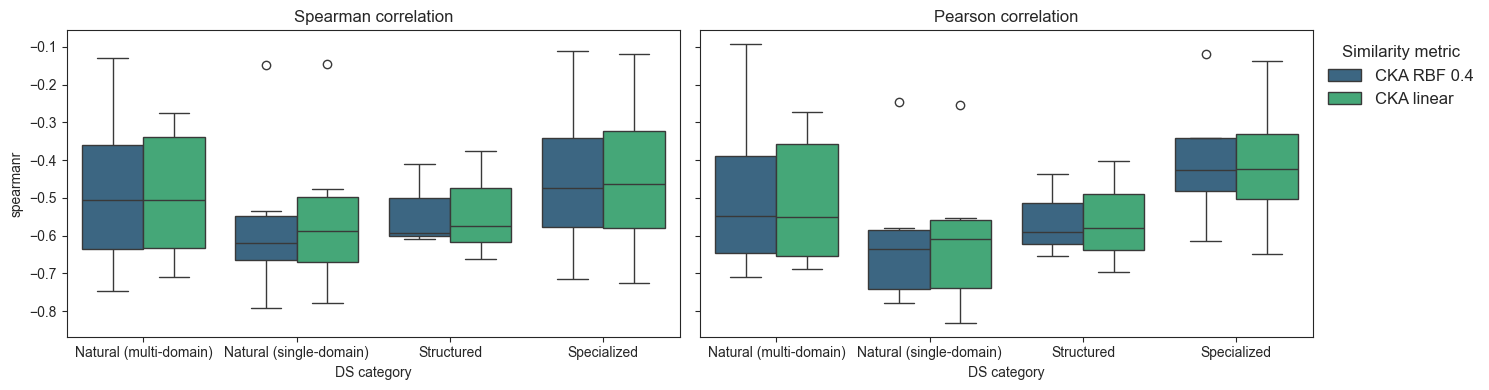

In [40]:
sns.set_style('ticks')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4), sharex=True, sharey=True)
sns.boxplot(
    data=r_coeffs,
    x='DS category',
    y='spearmanr',
    hue='Similarity metric',
    palette='viridis',
    ax=axes[0],
    
)
sns.boxplot(
    data=r_coeffs,
    x='DS category',
    y='pearsonr',
    hue='Similarity metric',
    palette='viridis',
    ax=axes[1],
)
# axes[0].xaxis.set_tick_params(rotation=20)
axes[0].get_legend().remove()
axes[0].set_title('Spearman correlation')
# axes[1].xaxis.set_tick_params(rotation=20)
axes[1].set_title('Pearson correlation')
sns.move_legend(axes[1], loc='upper left', title='Similarity metric', bbox_to_anchor=(1, 1), fontsize=12, title_fontsize=12, frameon=False)
fig.tight_layout()


In [42]:
r_coeffs.groupby(['Similarity metric'])['pearsonr'].describe()[['count', 'mean', 'std', '25%', '50%', '75%']]

,count,mean,std,25%,50%,75%
Similarity metric,,,,,,
CKA RBF 0.4,25.0,-0.516294,0.184417,-0.654995,-0.552316,-0.414638
CKA linear,25.0,-0.524533,0.177001,-0.649691,-0.553572,-0.394361


In [43]:
r_coeffs.groupby(['Similarity metric'])['spearmanr'].describe()[['count', 'mean', 'std', '25%', '50%', '75%']]

,count,mean,std,25%,50%,75%
Similarity metric,,,,,,
CKA RBF 0.4,25.0,-0.502889,0.191838,-0.650372,-0.581079,-0.408980
CKA linear,25.0,-0.504189,0.182802,-0.634004,-0.555781,-0.374608


In [39]:
r_coeffs.groupby(['Similarity metric', 'DS category'])['pearsonr'].describe()[['count', 'mean', 'std', '25%', '50%', '75%']]

count      mean       std  \
Similarity metric DS category                                          
CKA RBF 0.4       Natural (multi-domain)    12.0 -0.500012  0.180502   
                  Natural (single-domain)    6.0 -0.606654  0.194930   
                  Specialized                4.0 -0.395884  0.205435   
                  Structured                 3.0 -0.561249  0.111830   
CKA linear        Natural (multi-domain)    12.0 -0.514809  0.156917   
                  Natural (single-domain)    6.0 -0.603776  0.203656   
                  Specialized                4.0 -0.409035  0.211402   
                  Structured                 3.0 -0.558946  0.148121   

                                                25%       50%       75%  
Similarity metric DS category                                            
CKA RBF 0.4       Natural (multi-domain)  -0.645624 -0.547962 -0.389511  
                  Natural (single-domain) -0.742167 -0.635932 -0.584034  
                  Specialized             -0.481683 -0.426247 -0.340448  
                  Structured              -0.623140 -0.591285 -0.514377  
CKA linear        Natural (multi-domain)  -0.653724 -0.551599 -0.357696  
                  Natural (single-domain) -0.738772 -0.607755 -0.557379  
                  Specialized             -0.503522 -0.424580 -0.330093  
                  Structured              -0.637635 -0.579636 -0.490602

In [33]:
r_coeffs.groupby(['Similarity metric', 'DS category'])[['spearmanr', 'pearsonr']].agg(['count', 'mean', 'std', 'median'])

spearmanr                      \
                                              count      mean       std   
Similarity metric DS category                                             
CKA RBF 0.4       Natural (multi-domain)         12 -0.483855  0.185368   
                  Natural (single-domain)         6 -0.563930  0.221324   
                  Specialized                     4 -0.443327  0.252738   
                  Structured                      3 -0.536357  0.110605   
CKA linear        Natural (multi-domain)         12 -0.497038  0.162061   
                  Natural (single-domain)         6 -0.543590  0.221620   
                  Specialized                     4 -0.442234  0.255558   
                  Structured                      3 -0.536599  0.146888   

                                                    pearsonr            \
                                             median    count      mean   
Similarity metric DS category                                            
CKA RBF 0.4       Natural (multi-domain)  -0.504944       12 -0.500012   
                  Natural (single-domain) -0.620131        6 -0.606654   
                  Specialized             -0.473712        4 -0.395884   
                  Structured              -0.592000        3 -0.561249   
CKA linear        Natural (multi-domain)  -0.505722       12 -0.514809   
                  Natural (single-domain) -0.587427        6 -0.603776   
                  Specialized             -0.462515        4 -0.409035   
                  Structured              -0.574058        3 -0.558946   

                                                               
                                                std    median  
Similarity metric DS category                                  
CKA RBF 0.4       Natural (multi-domain)   0.180502 -0.547962  
                  Natural (single-domain)  0.194930 -0.635932  
                  Specialized              0.205435 -0.426247  
                  Structured               0.111830 -0.591285  
CKA linear        Natural (multi-domain)   0.156917 -0.551599  
                  Natural (single-domain)  0.203656 -0.607755  
                  Specialized              0.211402 -0.424580  
                  Structured               0.148121 -0.579636

In [30]:
print(r_coeffs.groupby(['Similarity metric', 'DS category'])[['spearmanr', 'pearsonr']].agg(['mean', 'std']).to_latex())

\begin{tabular}{llrrrr}
\toprule
 &  & \multicolumn{2}{r}{spearmanr} & \multicolumn{2}{r}{pearsonr} \\
 &  & mean & std & mean & std \\
Similarity metric & DS category &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{CKA RBF 0.4} & Natural (multi-domain) & -0.483855 & 0.185368 & -0.500012 & 0.180502 \\
 & Natural (single-domain) & -0.563930 & 0.221324 & -0.606654 & 0.194930 \\
 & Specialized & -0.443327 & 0.252738 & -0.395884 & 0.205435 \\
 & Structured & -0.536357 & 0.110605 & -0.561249 & 0.111830 \\
\cline{1-6}
\multirow[t]{4}{*}{CKA linear} & Natural (multi-domain) & -0.497038 & 0.162061 & -0.514809 & 0.156917 \\
 & Natural (single-domain) & -0.543590 & 0.221620 & -0.603776 & 0.203656 \\
 & Specialized & -0.442234 & 0.255558 & -0.409035 & 0.211402 \\
 & Structured & -0.536599 & 0.146888 & -0.558946 & 0.148121 \\
\cline{1-6}
\bottomrule
\end{tabular}

